## Student Name : Rakesh Paul
## Student ID : 22271872

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [3]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [4]:
# Check dataset balance based on type attribute.
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

## Binary Classification Problem formulation
The seeds dataset contains seven morpholigical feature and three types (Kama, Rosa, and Canadian) in which they belong to. To form a binary classification problem, one way to do this is combining two seed types into one group and classify them against the remaining type. Therefore, following is the proposed binary classification problem:
#### Features:
1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.

#### Target classification
The goal is is verify if a seed type is 2 or not. This way we can have a binary classification of the dataset based on `type`.

Consideration: Kama(0), Rosa(1), and Canadian(2)

Following is the binary classification problem: 
- Reassign `type` = 0 for original `type` 0 and 1
-  Reassign `type` = 1 for original `type` 2

Means:
1. Not Canadian (Kama and Rosa) : class 0
2. Canadian : class 1

Finally, The binary classification problem has two classes. Verify if a seed is class 1 (canadian) or not.

## Cost of misclassification
The cost of misclassification depends on the specific application and context of the problem.
For example,
- In some applications, the cost of a false positive might be higher than the cost of a false negative, or vice versa. For example, in medical diagnosis, a false negative (failing to identify a disease) might have more severe consequences than a false positive (identifying a disease when it's not actually present). If the cost of misclassification is high, we can try to optimize the precision metric to ensure that the model has a low false positive rate (FPR).

- Some applications gives more importance to minimizing false negatives while some at minimizing false positives. If the cost of misclassification is the same for both class, we might want to optimize the F1-score, which balances precision and recall metric. It will balance the trade-off between minimizing false positive and false negative rate.

Overall, the cost of misclassification must be very carefully analyzed as it has a signification impact for the model performance.

In [5]:
# Create binary classification by transforming the `type` column
df['type'] = df['type'].apply(lambda x: 0 if x == 1 or x == 2 else 1)

In [6]:
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

First of all let's check for missing values and outliers.

In [7]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers. We will do this in three slices.

In [8]:
numeric_columns = df.drop(columns=["type"]).select_dtypes(include=['float64', 'int64']).columns.tolist()
print(numeric_columns)

['area', 'perimeter', 'compactness', 'length of kernel', 'width of kernel', 'asymmetry coefficient', 'length of kernel groove']


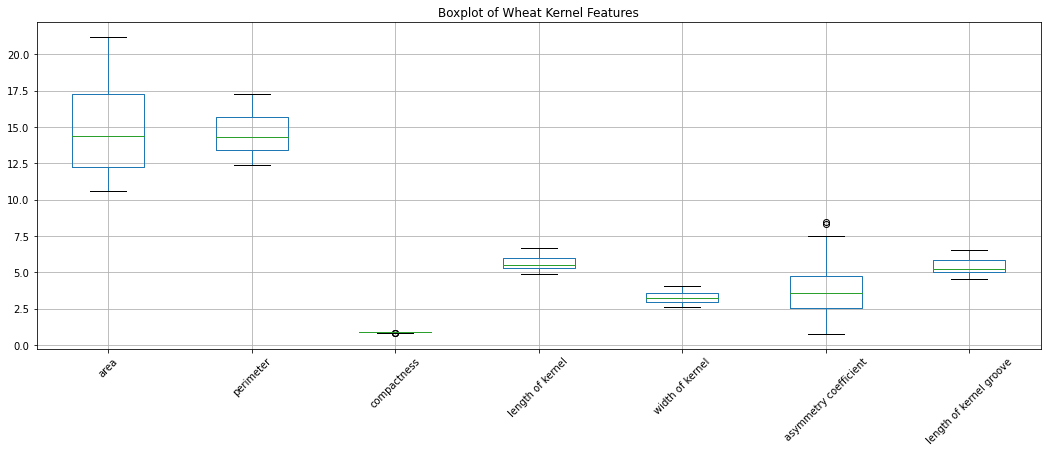

In [9]:
df_features = df.drop(columns=["type"])

# Create a boxplot for each feature using pandas DataFrame's boxplot method
plt.figure(figsize=(18, 6))
df_features.boxplot()
plt.title("Boxplot of Wheat Kernel Features")
plt.xticks(range(1, len(df_features.columns) + 1), df_features.columns, rotation=45)
plt.show()

### Analysis of Outliers
- The `asymmetry coefficient` attribute appears to have several prominent outliers. We will apply log transformation followed by `RobustScaler` to them.
- The `compactness` attribute has few outliers. Because of very small scale compared to other attributes, they are not so prominent. We will apply log transformation followed by `RobustScaler` to them.
- Other attributes does not have any outlier. We will apply `StandardScaler` to them.

## Data Preparation

We will attempt training SVM and Random Forest classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of these pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, we need to prepare two lists of column names. The list `names_outliers` contains the names of the three columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [10]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['compactness', 'asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns. 

In [11]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [12]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`. 

In [13]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [14]:
y = df['type']
X = df.drop('type', axis=1).values

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters of Classifiers

Next, we train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [15]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search_svm = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)

The parameter `refit=True` makes the GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

Let's repeat the same experiment but with the Random Forest classifier.

In [16]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search_rf = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)

## Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [17]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [18]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [29]:
def ExecuteModel(model, X, y, name, num_runs=10):

    # Initialize the lists to store the evaluation metrics for each run
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    tpr_list = []
    auc_list = []

    best_model = None
    best_score = -np.inf
    best_params = None

    for i in range(num_runs):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

        model.fit(X_train, y_train) 
        
        score = model.best_score_
        if score > best_score:
            best_params = model.best_params_
            best_score = score

            best_model = model.best_estimator_

        accuracy, precision, recall, f1_score, tpr, auc = evaluate_model(X_test, y_test, model.best_estimator_)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        tpr_list.append(tpr)
        auc_list.append(auc)
        
    print("Best CV score = %0.3f:" % model.best_score_)
    print("Best parameters: ", model.best_params_)

    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1_score = np.mean(f1_score_list)
    avg_tpr = np.mean(tpr_list, axis=0)
    avg_auc = np.mean(auc_list)

    print(f"Average", name, f" Accuracy: {avg_accuracy:.2f}")
    print(f"Average", name, f" Precision: {avg_precision:.2f}")
    print(f"Average", name, f" Recall: {avg_recall:.2f}")
    print(f"Average", name, f" F1-score: {avg_f1_score:.2f}")

    return avg_accuracy, avg_precision, avg_recall, avg_f1_score, avg_tpr, avg_auc, best_params

#### Train
Train SVM and Random Forest classifiers and evaluate model for predicting probability of testing data belonging to class 1. As the train_test_split() method splits the dataset randomly for every call, executing the training and evaliation process for multiple runs (10) and taking an average value for every metric gives a stable score. Best model is chosen based on best CV score.

In [20]:
avg_SVM_accuracy, avg_SVM_precision, avg_SVM_recall, avg_SVM_f1_score, avg_SVM_tpr, avg_SVM_auc, svm_best_params = ExecuteModel(search_svm, X, y, "svm")

avg_RF_accuracy, avg_RF_precision, avg_RF_recall, avg_RF_f1_score, avg_RF_tpr, avg_RF_auc, rf_best_params = ExecuteModel(search_rf, X, y, "RF")

Best CV score = 0.976:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Average svm  Accuracy: 0.95
Average svm  Precision: 0.93
Average svm  Recall: 0.93
Average svm  F1-score: 0.93
Best CV score = 0.959:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 30}
Average RF  Accuracy: 0.93
Average RF  Precision: 0.89
Average RF  Recall: 0.89
Average RF  F1-score: 0.89


We will use a pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

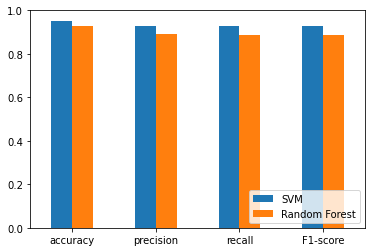

In [21]:
SVM_metrics = np.array([avg_SVM_accuracy, avg_SVM_precision, avg_SVM_recall, avg_SVM_f1_score])
RF_metrics = np.array([avg_RF_accuracy, avg_RF_precision, avg_RF_recall, avg_RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

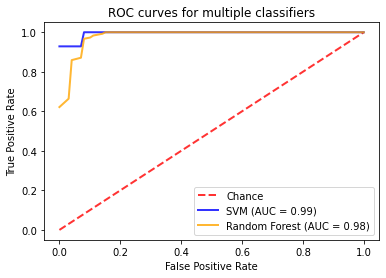

In [22]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, avg_SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (avg_SVM_auc), alpha=0.8)
plt.plot(mean_fpr, avg_RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (avg_RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### Explored parameters 
Following hyperparameters are verified using GridSearchCV() for different combination of values of each parameter for:

<b> SVM classifer</b> 
- C : [0.1, 1, 10, 100]
- gamma : [1, 0.1, 0.01, 0.001]
- kernel : ['rbf', 'linear', 'poly']

<b> Random Foresr classifier </b>
- n_estimators : [10,20,30]
- max_depth : [2, 4, 6, 8]

### Conclusion
- <b> SVM classifier </b> gave best result in all the above evaluation metrics (CV score 0.976). Accuracy value (0.95) is bit higher than Recall (0.93), precision (0.93) and F1-score (0.93). It indicates that SVM classifier perform better at identifying Canadian seed (class 1) type overall.

- <b> Random forest classifier </b> also performed fairly well in all the above evaluation metrics (CV score 0.959). Therefore, both the model are identifying the underlying pattern of the dataset effectively. However, the Recall score (0.89) of Random Forest is much lower than SVM classifier, meaning the model is missing few more positive cases at idetifying Canadian seed (class 1) type.

- The ROC curves shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) for different classification thresholds. SVM classifier AUC value (0.99) is a bit better than Random forest classifier's AUC (0.98). A model with a higher AUC is considered to be better than a model with a lower AUC.

Therefore, the average performance of SVM classifier is better and can be considered as the best model for the dataset having  parameter set:
{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

## Task 3
Create an MLP classifier with following hyperparameters and train the dataset:
- hidden_layers
- activation function
- solver
- alpha

#### Grid Search 
Train an MLP classifier with the training set and a range of possible parameters in order to find the best parameters for MLPClassifier by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the MLPClassifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

Hyper-parameter set:
- hidden_layers : [(5,), (10,), (20,)]
- activation function : ['relu', 'tanh', 'logistic']
- solver : ['lbfgs', 'sgd', 'adam']
- alpha : [0.0001, 0.001, 0.01]

In [23]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('MLP classifier', MLPClassifier(max_iter=1000))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of MLPClassifier and their possible values

param_grid = {
    'MLP classifier__hidden_layer_sizes': [(5,), (10,), (20,)],
    'MLP classifier__activation': ['relu', 'tanh', 'logistic'],
    'MLP classifier__solver': ['lbfgs', 'sgd', 'adam'],
    'MLP classifier__alpha': [0.0001, 0.001, 0.01]
}

search_mlp = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)

#### Train
Perform MLP classification on the same training dataset and evaluate model (10 times average) for predicting probability of testing data belonging to class 1.

In [24]:
avg_MLP_accuracy, avg_MLP_precision, avg_MLP_recall, avg_MLP_f1_score, avg_MLP_tpr, avg_MLP_auc, MLP_best_params = ExecuteModel(search_mlp, X, y, "mlp")

Best CV score = 0.971:
Best parameters:  {'MLP classifier__activation': 'relu', 'MLP classifier__alpha': 0.0001, 'MLP classifier__hidden_layer_sizes': (5,), 'MLP classifier__solver': 'lbfgs'}
Average mlp  Accuracy: 0.94
Average mlp  Precision: 0.89
Average mlp  Recall: 0.92
Average mlp  F1-score: 0.91


We will use a pandas bar plot to compare the accuracies of SVM, Random Forest and MLP classifier models as well as their precision, recall and F1-score for class 1. 

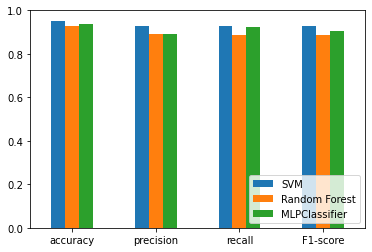

In [25]:
MLP_metrics = np.array([avg_MLP_accuracy, avg_MLP_precision, avg_MLP_recall, avg_MLP_f1_score])
df_metrics['MLPClassifier'] = MLP_metrics
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

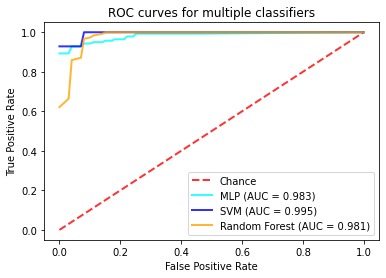

In [26]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, avg_MLP_tpr[0,:], lw=2, color='cyan', label='MLP (AUC = %0.3f)' % (avg_MLP_auc), alpha=0.8)
plt.plot(mean_fpr, avg_SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.3f)' % (avg_SVM_auc), alpha=0.8)
plt.plot(mean_fpr, avg_RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.3f)' % (avg_RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

## Comparison
- SVM classifier has highest average accuracy (0.95) and the highest average precision (0.93), meaning it performs well in both correctly identifying positive instances and avoiding false positives. 
- MLP classifier has second-highest average accuracy (0.94) and second-highest average recall (0.92). This means, it performs fairly well in correctly identifying positive instances, but have more false positives compared to SVM classifier. 
- Random Forest classifier has the lowest average accuracy (0.93) and recall (0.89), making it less effective at correctly identifying positive instances. But the second-highest average precision (0.89) along with random forest indicates that it still performs well avoiding false positives.
- SVM classifier has highest F1-score (0.93), followed by MLP (0.91) and the Random Forest (0.89). SVM is the best overall performer.
- SVM has highest AUC score of 0.995, followed by MLP and Random Forest with AUC scores of 0.983 & 0.981 respectively. The ROC curve also reflects the same with MLP ROC curve in between SVM and Random Forest curve.

Therefore, SVM is the best classifier for the dataset based on all metrics scores and also having best CV score (0.976) followed by MLP (0.971) and Random Forest (0.959) on unseen data.

## Train a Final Model

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [27]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(svm_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [28]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))